# Data visualization : milestone 1 

## Dataset

For our project, we found interesting to take a record of some of the 911 calls in Montgomery County, in the Commonwealth of Pennsylvania.

You can find the data set here : https://www.kaggle.com/datasets/mchirico/montcoalert.

#### Read the data

In [65]:
import numpy as np 
import pandas as pd
import datetime
import os
import plotly.figure_factory as ff
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)

In [66]:
data_folder = './input/'

for dirname, _, filenames in os.walk(data_folder):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        file_location = os.path.join(dirname, filename)

./input/.DS_Store
./input/911.csv
./input/archive.zip


In [67]:
dateparse = lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S')

# Read data 
calls_data =pd.read_csv(file_location,
    header=0,names=['lat', 'lng','desc','zip','title','timeStamp','twp','addr','e'],
    dtype={'lat':str,'lng':str,'desc':str,'zip':str,
                  'title':str,'timeStamp':str,'twp':str,'addr':str,'e':int}, 
     parse_dates=['timeStamp'],date_parser=dateparse)


# Set timeStamp
calls_data.timeStamp = pd.DatetimeIndex(calls_data.timeStamp)

In [68]:
calls_data.head()

,lat,lng,desc,zip,title,timeStamp,twp,addr,e
0,40.2978759,-75.5812935,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525,EMS: BACK PAINS/INJURY,2015-12-10 17:10:52,NEW HANOVER,REINDEER CT & DEAD END,1
1,40.2580614,-75.2646799,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446,EMS: DIABETIC EMERGENCY,2015-12-10 17:29:21,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1
2,40.1211818,-75.3519752,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401,Fire: GAS-ODOR/LEAK,2015-12-10 14:39:21,NORRISTOWN,HAWS AVE,1
3,40.1161530,-75.3435130,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401,EMS: CARDIAC EMERGENCY,2015-12-10 16:47:36,NORRISTOWN,AIRY ST & SWEDE ST,1
4,40.2514920,-75.6033497,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,2015-12-10 16:56:52,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,1


From a first look, the data set seems realtively clean. There could be some NaN on the zip information or other columns.

#### First look at the data

In [69]:
calls_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663522 entries, 0 to 663521
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   lat        663522 non-null  object        
 1   lng        663522 non-null  object        
 2   desc       663522 non-null  object        
 3   zip        583323 non-null  object        
 4   title      663522 non-null  object        
 5   timeStamp  663522 non-null  datetime64[ns]
 6   twp        663229 non-null  object        
 7   addr       663522 non-null  object        
 8   e          663522 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 45.6+ MB


Expect for the zip column, all the others columns not contain any missing values.

The description column must be pretty unique. Let us check if there is any duplicates on that column.

In [70]:
len(calls_data['desc'].drop_duplicates())

663282

In [71]:
print("percentage of duplicates dropped in the description column :", (1 - len(calls_data['desc'].drop_duplicates()) / len(calls_data))*100)

percentage of duplicates dropped in the description column : 0.036170616799446886


This column does not seem to have loads (less than 1%) of duplicates values. It is important since it contains lots of valuable information.

The data set seems relatively big enough to perfom some interesting vizualizations. 

It do not contain a major number of duplicates or missing values on important column, so the cleaning / pre-processing part will not be very difficult to tackle.

### Cleaning and Preprocessing

In [72]:
clean_calls_data = calls_data.copy()

In [73]:
# Drop duplicates in the description column
clean_calls_data = calls_data.drop_duplicates("desc")

# Drop the NA's
clean_calls_data = clean_calls_data.dropna()

# Create a new group column for each main category (EMS / Traffic / Fire) of the title column 
clean_calls_data['group'] = clean_calls_data['title'].apply(lambda x: x.split(':')[0])

# Create a year column for time series plots
clean_calls_data["year"] = clean_calls_data['timeStamp'].dt.year

clean_calls_data.head()

,lat,lng,desc,zip,title,timeStamp,twp,addr,e,group,year
0,40.2978759,-75.5812935,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525,EMS: BACK PAINS/INJURY,2015-12-10 17:10:52,NEW HANOVER,REINDEER CT & DEAD END,1,EMS,2015
1,40.2580614,-75.2646799,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446,EMS: DIABETIC EMERGENCY,2015-12-10 17:29:21,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1,EMS,2015
2,40.1211818,-75.3519752,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401,Fire: GAS-ODOR/LEAK,2015-12-10 14:39:21,NORRISTOWN,HAWS AVE,1,Fire,2015
3,40.1161530,-75.3435130,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401,EMS: CARDIAC EMERGENCY,2015-12-10 16:47:36,NORRISTOWN,AIRY ST & SWEDE ST,1,EMS,2015
5,40.2534732,-75.2832450,CANNON AVE & W 9TH ST; LANSDALE; Station 345;...,19446,EMS: HEAD INJURY,2015-12-10 15:39:04,LANSDALE,CANNON AVE & W 9TH ST,1,EMS,2015


After checking the zip codes and the map, there are some outliers to the data set (c.f. zip codes of Montgomery County, Pennsylvania). 

Let us filter these out.

In [74]:
#Filter zip outliers
clean_calls_data['zip_initial'] = clean_calls_data['zip'].str[:2]

clean_calls_data['zip_initial'] = pd.to_numeric(clean_calls_data['zip_initial'])

clean_calls_data = clean_calls_data.query('zip_initial >= 18')

#### Time series

In [75]:
n_calls_per_year = clean_calls_data.groupby('year')['e'].agg(['count'])

n_calls_per_year = pd.DataFrame(n_calls_per_year).reset_index()

n_calls_per_year

,year,count
0,2015,6890
1,2016,124458
2,2017,123717
3,2018,132549
4,2019,130631
5,2020,64711


Text(0.5, 1.0, 'Number of calls per year')

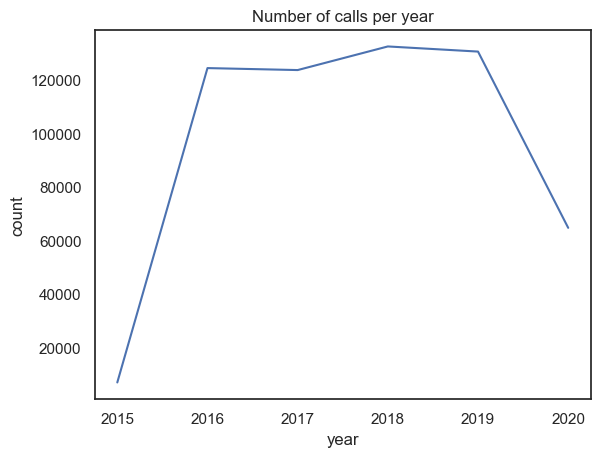

In [76]:
sns.lineplot(data =n_calls_per_year, x = 'year', y = 'count')
plt.title('Number of calls per year')

It would make sense to start the data from 2016 on, since it does not contain loads of data. 

For the decline in 2020, we could remove some of the months since the slope seems less important than the one from 2015-2016, but let us first analyze those years.

In [77]:
clean_calls_data = clean_calls_data[(clean_calls_data.timeStamp >= "2016-01-01 00:00:00")]

It seems that the 2020 year have much less 911 calls than the other years. Could that be because another event (like COVID for example) or is it because the data set is incomplete ? (or both) 

Let us take a deeper look at the 2019 and 2020 year, specifically.

In [78]:
calls_19 = clean_calls_data.query('year >= 2019 ')

calls_19['month_year'] = calls_19['timeStamp'].apply(lambda x: x.strftime('%m-%Y'))

# Create a pivot table to count the calls per week
calls_pivot = pd.pivot_table(calls_19, values='e', index=['timeStamp'], columns=['group'], aggfunc=np.sum)

# Creating counts per group per week
calls_pivot = calls_pivot.resample('W').agg(np.sum).reset_index()
calls_pivot.head()

group,timeStamp,EMS,Fire,Traffic
0,2019-01-06,1085.0,261.0,568.0
1,2019-01-13,1293.0,324.0,822.0
2,2019-01-20,1251.0,329.0,702.0
3,2019-01-27,1302.0,495.0,922.0
4,2019-02-03,1249.0,465.0,959.0


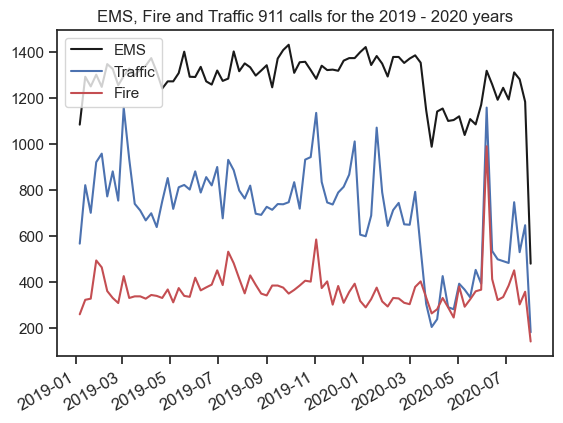

In [79]:
# Red dot with Line
fig, ax = plt.subplots()

ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left() 
plt.xticks(fontsize=12) 

ax.plot_date(calls_pivot['timeStamp'], calls_pivot['EMS'],'k', label = 'EMS')
ax.plot_date(calls_pivot['timeStamp'], calls_pivot['Traffic'],'b', label = 'Traffic')
ax.plot_date(calls_pivot['timeStamp'], calls_pivot['Fire'],'r', label = 'Fire')


ax.set_title("EMS, Fire and Traffic 911 calls for the 2019 - 2020 years")
fig.autofmt_xdate()
plt.legend(loc = 'upper left')
plt.show()


We can observe two things: 

- The data set stops at august 2020, not as the other years as they are complete. The 2020 year has 4 months of calls missing compared to the other years.

- There is a decrease in the calls around march-april 2020 ; it could be correlated with the COVID-19 crisis but further researches to support that hypothesis must be done.

We should remove the end months of 2020, since after the decrease there seems to be a significant increase in calls.

In [80]:
calls_pivot_20 = calls_pivot[(calls_pivot.timeStamp >= "2020-01-01 00:00:00")]

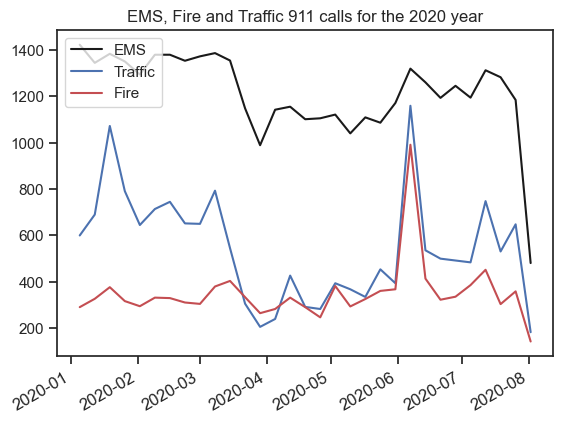

In [81]:
# Red dot with Line
fig, ax = plt.subplots()

ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left() 
plt.xticks(fontsize=12) 

ax.plot_date(calls_pivot_20['timeStamp'], calls_pivot_20['EMS'],'k', label = 'EMS')
ax.plot_date(calls_pivot_20['timeStamp'], calls_pivot_20['Traffic'],'b', label = 'Traffic')
ax.plot_date(calls_pivot_20['timeStamp'], calls_pivot_20['Fire'],'r', label = 'Fire')


ax.set_title("EMS, Fire and Traffic 911 calls for the 2020 year")
fig.autofmt_xdate()
plt.legend(loc = 'upper left')
plt.show()

It seems reasonable to cut July and August of the time frame for the 2020 year, which contains much less data than the other months.

In [82]:
july_august = calls_pivot_20[(calls_pivot_20.timeStamp > "2020-06-28 00:00:00")]

july_august

group,timeStamp,EMS,Fire,Traffic
78,2020-07-05,1194.0,386.0,484.0
79,2020-07-12,1312.0,452.0,748.0
80,2020-07-19,1282.0,304.0,531.0
81,2020-07-26,1184.0,359.0,648.0
82,2020-08-02,481.0,143.0,183.0


In [83]:
clean_calls_data = clean_calls_data[(clean_calls_data.timeStamp <= "2020-06-28 00:00:00")]

In [84]:
clean_calls_data['month_year'] = clean_calls_data['timeStamp'].apply(lambda x: x.strftime('%m-%Y'))

# Create a pivot table to count the calls per week
clean_calls_pivot = pd.pivot_table(clean_calls_data, values='e', index=['timeStamp'], columns=['group'], aggfunc=np.sum)

# Creating counts per group per week
clean_calls_pivot = clean_calls_pivot.resample('W').agg(np.sum).reset_index()
clean_calls_pivot.head()

group,timeStamp,EMS,Fire,Traffic
0,2016-01-03,503.0,101.0,215.0
1,2016-01-10,1248.0,395.0,759.0
2,2016-01-17,1255.0,309.0,984.0
3,2016-01-24,1285.0,534.0,1318.0
4,2016-01-31,1251.0,329.0,1023.0


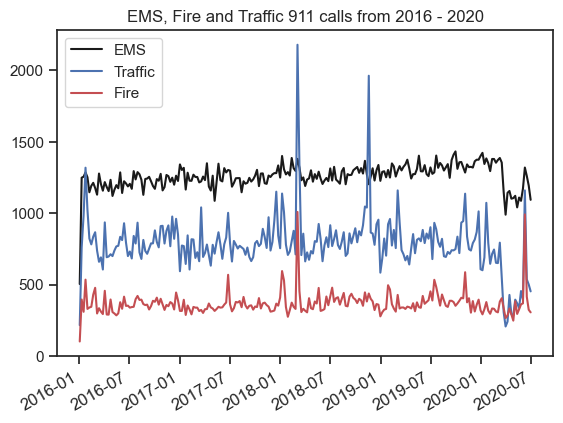

In [85]:
# Red dot with Line
fig, ax = plt.subplots()

ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left() 
plt.xticks(fontsize=12) 

ax.plot_date(clean_calls_pivot['timeStamp'], clean_calls_pivot['EMS'],'k', label = 'EMS')
ax.plot_date(clean_calls_pivot['timeStamp'], clean_calls_pivot['Traffic'],'b', label = 'Traffic')
ax.plot_date(clean_calls_pivot['timeStamp'], clean_calls_pivot['Fire'],'r', label = 'Fire')


ax.set_title("EMS, Fire and Traffic 911 calls from 2016 - 2020")
fig.autofmt_xdate()
plt.legend(loc = 'upper left')
plt.show()

## Exploratory Data Analysis

Let us begin with vizualizing just simple counts of the values in our data set.

Text(0.5, 0, 'Number of 911 calls')

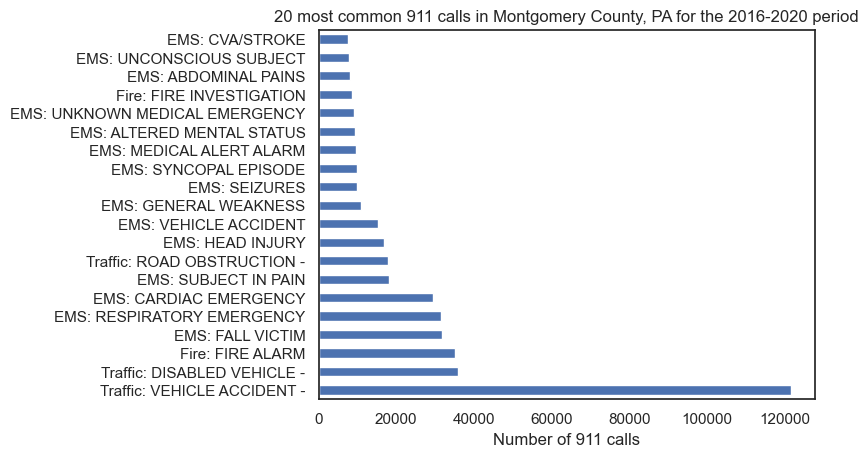

In [86]:
# Print the numbers of different values for the title column
clean_calls_data["title"].value_counts()[:20].plot(kind="barh")
plt.title('20 most common 911 calls in Montgomery County, PA for the 2016-2020 period')
plt.xlabel('Number of 911 calls')


Traffic problems have the most calls over the years, followed by fire alarm accidents and fall victim emergencies.

Vehicle accidents surpass the others by far.

In [87]:
clean_calls_data["group"].value_counts()

EMS        295551
Traffic    184456
Fire        86145
Name: group, dtype: int64

We can see that EMS (Emergency medical services) are the highest number of the calls made in the county, followed by traffic and fire.

Although, it seems that it is because Traffic only have few titles compared to the EMS one, that is categorize into more several titles.

#### Calls per time of the day

Let us plot a heatmap of the most common call type and see how it evolve depending on the hour of the day.

In [88]:
vehicle_accidents = clean_calls_data[(clean_calls_data.title.str.match(r'EMS:.*VEHICLE ACCIDENT.*') | clean_calls_data.title.str.match(r'Traffic:.*VEHICLE ACCIDENT.*'))]

vehicle_accidents['Month'] = vehicle_accidents['timeStamp'].apply(lambda x: x.strftime('%m %B'))
vehicle_accidents['Hour'] = vehicle_accidents['timeStamp'].apply(lambda x: x.strftime('%H'))

pivot_table_accidents = pd.pivot_table(vehicle_accidents, values='e', index=['Month'] , columns=['Hour'], aggfunc=np.sum)

pivot_table_accidents.head()

Hour,00,01,02,03,04,05,06,07,08,09,...,14,15,16,17,18,19,20,21,22,23
Month,,,,,,,,,,,,,,,,,,,,,
01 January,115,101,99,87,87,121,396,740,933,647,...,855,959,980,1276,939,592,400,363,223,181
02 February,110,105,79,55,51,135,339,682,687,596,...,753,902,866,851,827,608,388,287,205,208
03 March,131,104,96,65,79,122,299,609,677,632,...,871,1017,1074,996,657,563,433,345,239,178
04 April,118,71,81,50,72,94,238,528,590,509,...,798,915,1004,879,637,338,353,261,203,134
05 May,110,102,76,64,67,91,252,617,674,617,...,928,1094,1130,1129,710,427,386,360,252,197


Text(0.5, 1.0, 'Vehicle Accidents during the period 2016-2020, over all townships in Montgomery County, PA')

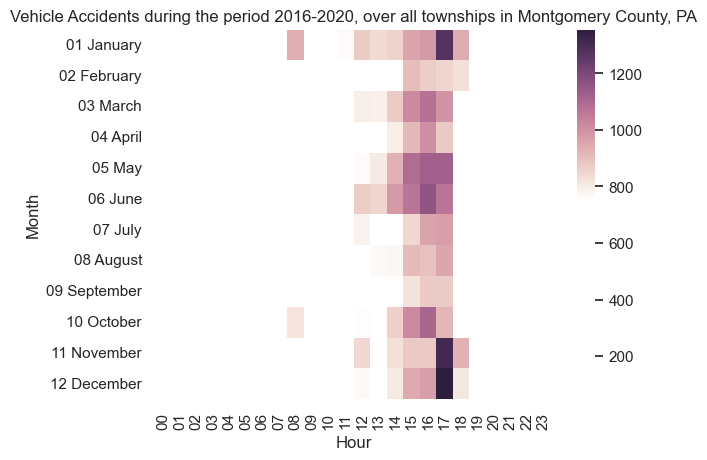

In [89]:
cmap = sns.cubehelix_palette(light=2, as_cmap=True)

ax = sns.heatmap(pivot_table_accidents, cmap = cmap)

ax.set_title('Vehicle Accidents during the period 2016-2020, over all townships in Montgomery County, PA')

We can observe that most of the vehicle accidents are during november / december / january, especially at 5 pm.

It could be because it is the end of the day so people are more tired and focused than the beginning of the day; it corresponds fairly to the end of the working time, people could be tired and want to go home rather quickly.

It could also be because during winter there is less visibilty on the road or more severe weather than during the spring or summer.

Sun goes down at approximatively 4.30 pm during the winter, in december (c.f. https://www.timeanddate.com/sun/@5201756?month=12&year=2019), which could explain more accident.

#### Calls per regions

In [90]:
regions = clean_calls_data.copy()

sorted_regions = regions.groupby('zip')['e'].agg(['count']).sort_values('count', ascending=False)

sorted_regions = pd.DataFrame(sorted_regions).reset_index()

sorted_regions.head(10)

,zip,count
0,19401,44171
1,19464,42611
2,19403,33881
3,19446,31292
4,19406,21769
5,19002,20521
6,19468,18385
7,19046,17396
8,19454,17117
9,19090,16841


It clearly seems that there are "hotspots" for calls in the county.

In [ ]:
import plotly.express as px
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/OpenDataDE/State-zip-code-GeoJSON/master/pa_pennsylvania_zip_codes_geo.min.json') as response:
    zipcodes = json.load(response)

In [ ]:
fig = px.choropleth(sorted_regions, 
                    geojson=zipcodes,
                    locations='zip', 
                    color='count',
                    featureidkey="properties.ZCTA5CE10"
)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_geos(fitbounds="locations", visible=True)

In [91]:
sorted_regions_grouped = clean_calls_data.groupby(['zip', 'group'])['e'].agg(['count']).sort_values('count', ascending=False)

sorted_regions_grouped = pd.DataFrame(sorted_regions_grouped).reset_index()

sorted_regions_grouped.head(10)

,zip,group,count
0,19401,EMS,28650
1,19464,EMS,25186
2,19403,EMS,21764
3,19446,EMS,17748
4,19406,EMS,11408
5,19464,Traffic,10155
6,19002,EMS,9658
7,19401,Traffic,9616
8,19446,Traffic,9586
9,19468,EMS,9311
